# 第一个数据集：PPMI 1*294=2*98+98=98+98+98

来自Dr.SheN贴心的注释：

每次训练的时候，请在上方选择：Kernel-Restart and Run All哦，不然可能出现一些小问题

默认算法：线性回归

默认数据集：PPMI

默认training set：validation set：test set = 8：1：1

默认优化算法：SGD

默认loss：MSELoss（如果是深度方法，由于是二分类问题，建议改成BCE Loss）

这份代码默认实现的是线性回归的训练代码，如果要改成深度方法的代码，要注意outputs = net(inputs)的前向传播的维度和输出。

## 数据集探索

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
data = sio.loadmat('PPMI.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 15 16:16:33 2021',
 '__version__': '1.0',
 '__globals__': [],
 'NC': array([[3388, 4966, 4946, ...,  414,  639,  616],
        [3477, 2667, 3126, ...,  434,  678,  614],
        [3774, 5791, 3636, ...,  294,  509,  487],
        ...,
        [5318, 4989, 6339, ...,  479,  821,  736],
        [3228, 4514, 7793, ...,  383,  673,  603],
        [3870, 3959, 3314, ...,  414,  761,  771]], dtype=uint16),
 'PD': array([[4362, 4543, 4222, ...,  412,  728,  751],
        [4564, 4011, 4284, ...,  340,  483,  615],
        [3342, 4094, 5394, ...,  479,  585,  600],
        ...,
        [5902, 6280, 5432, ...,  398,  600,  540],
        [3678, 2737, 3252, ...,  419,  548,  540],
        [4160, 3962, 3423, ...,  402,  592,  620]], dtype=uint16)}

In [3]:
x_positive = data['NC']
x_negative = data['PD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)



有169个正样本，有374个负样本，一共有543个样本
x原本是只有一个特征的，为294维
(169, 294) (374, 294) (543, 294) (169,) 374 169 294


## 利用TSNE和PCA的可视化，发现几乎不具有线性可分性

In [4]:
x_tsne = TSNE(n_components=2).fit_transform(x_total)
print(x_tsne.shape)

(543, 2)


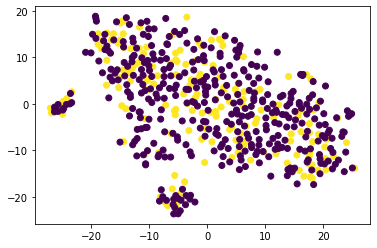

In [5]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = list(y_total))

In [6]:
x_pca = PCA(n_components=2).fit_transform(x_total)
print(x_pca.shape)

(543, 2)


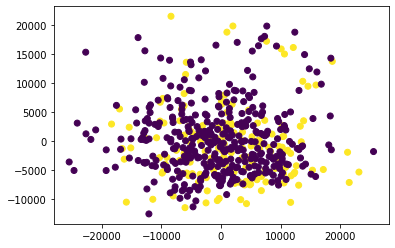

In [7]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = list(y_total))

## 数据预处理（划分train/test dataset和载入dataloader）

In [8]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import random
random.seed(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
################# batch_size也是一个超参数，第一个调整的参数就是batch_size,可选：1，2，4，8，16，32。
batch_size = 4

train_size = int(0.8*x_total.shape[0])
test_size = int(0.9*x_total.shape[0])

mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
random.shuffle(mixed)
# print(mixed)
x_train = mixed[:train_size, :dim_input]
y_train = mixed[:train_size, dim_input:]
print(x_train.shape, y_train.shape)
x_val = mixed[train_size:test_size, :dim_input]
y_val = mixed[train_size:test_size, dim_input:]
print(x_val.shape, y_val.shape)
x_test = mixed[test_size:, :dim_input]
y_test = mixed[test_size:, dim_input:]
print(x_test.shape, y_test.shape)

train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)
print(len(train_data), len(val_data), len(test_data))

(434, 294) (434, 1)
(54, 294) (54, 1)
(55, 294) (55, 1)
434 54 55


下面只需要用train_loader作为迭代器，用x_val,y_val（迭代器val_loader）来调参，当在x_val和y_val上达到最优的时候，在x_test(test_loader)上测试一次，作为一个算法的最终结果

In [9]:
########### 用于eval，非必要不改动
########### 敏感性即召回率，true positive rate = TP/(TP+FN)
########### 特异度为true negative rate = TN/(FP+TN)
def evaluate_accuracy(loader, net):
    net.eval()
    sum_all = 0
    sum_acc = 0
    FN = 0
    TN = 0
    TP = 0
    FP = 0
    
    for index, (data, label) in enumerate(loader):
        with torch.no_grad():
            data = Variable(data, requires_grad=True).to(device)
            label = Variable(label, requires_grad=True).to(device)
        outputs = (net(data) > 0.5).type(torch.float)
#         print(outputs.shape, label.shape)
        sum_acc += torch.sum(outputs.argmax(0) == label)
        for i in range(outputs.shape[0]):
            if outputs[i, 0] == label[i] and label[i] == 1:
                TP += 1
            elif outputs[i, 0] == label[i] and label[i] == 0:
                TN += 1
            elif outputs[i, 0] != label[i] and label[i] == 1:
                FN += 1
            else:
                FP += 1
        sum_all += data.shape[0]
    print('total validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
    acc = sum_acc / sum_all
    net.train()
    sensitivity = TP / (TP + FN)
    specificity = TN / (FP + TN)
    return acc, sensitivity, specificity

## 实现算法一（传统方法）

In [10]:
##############在class里面定义自己的算法，xxxx是算法的名字。
class xxxx(nn.Module):
    def __init__(self, n_feature):
        super(xxxx, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear.weight.data.uniform_(-1, 1)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        y = self.linear(x)
        return torch.sigmoid(y)
    
# net = LinearNet(dim_input).to(device)
# print(net) # 使用print可以打印出网络的结构

## 实现算法二（传统方法/深度方法）

In [11]:
##############在class里面定义自己的算法，xxxx是算法的名字。
class xxxx(nn.Module):
    def __init__(self, n_feature):
        super(xxxx, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear.weight.data.uniform_(-1, 1)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        y = self.linear(x)
        return torch.sigmoid(y)
    
# net = LinearNet(dim_input).to(device)
# print(net) # 使用print可以打印出网络的结构

## 实现算法三（深度方法）

In [12]:
##############在class里面定义自己的算法，xxxx是算法的名字。
class xxxx(nn.Module):
    def __init__(self, n_feature):
        super(xxxx, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear.weight.data.uniform_(-1, 1)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        y = self.linear(x)
        return torch.sigmoid(y)
    
# net = LinearNet(dim_input).to(device)

# print(net) # 使用print可以打印出网络的结构

## 训练准备（目标函数、优化方法、超参数）

In [13]:
learning_rate = 0.01 # 学习率
num_epochs = 5 # 训练的epoch

In [14]:
######### 实例化算法对象
xx = xxxx(dim_input).to(device)
######### 选择损失函数MSELoss
criterion = nn.BCELoss().to(device)
########### 选择minibatch SGD算法
learning_rate = 0.0001
########## 这里面的xxxx是算法对象的实例化，我们的优化算法固定为SGD，可选momentum和nesterov，lr为超参数需要调优
optimizer = optim.SGD(xx.parameters(), lr=learning_rate)

## 具体训练代码

In [15]:
#########  训练过程，可以不动它
losses = []
accuracy = []
sensitivity = []
specificity = []
preds = []
labels = []
print_every = 10
print_loss_total = 0
for epoch in range(num_epochs):
    xx.train()
    print('Epoch:{}'.format(epoch+1))
    for index, (data, label) in enumerate(train_loader):
        data = Variable(data, requires_grad=True).to('cuda')
        label = Variable(label, requires_grad=True).to('cuda')
        for i in range(data.shape[0]):
            preds.append(xx(data[i]).detach().cpu())
            labels.append(label[i].detach().cpu())
        
        outputs = xx(data)
        
        loss = criterion(outputs, label.detach())
        print_loss_total += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if index % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print('\tloss:{}'.format(print_loss_avg))
            losses.append(print_loss_avg)
            print_loss_total = 0
    acc, sen, spe = evaluate_accuracy(val_loader, xx)
    accuracy.append(acc)
    sensitivity.append(sen)
    specificity.append(spe)
    print('Epoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch, acc, sen, spe))

Epoch:1
	loss:2.5
	loss:15.0
	loss:25.0
	loss:30.0
	loss:27.5
	loss:30.0
	loss:32.5
	loss:32.5
	loss:25.0
	loss:27.5
	loss:30.0
total validation set data:54, numbers of accurately labeled data:36
Epoch:0, Accuracy:0.6666666865348816, Sensitivity:1.0, Specificity:0.18181818181818182
Epoch:2
	loss:15.0
	loss:30.0
	loss:37.5
	loss:30.0
	loss:35.0
	loss:25.0
	loss:17.5
	loss:25.0
	loss:32.5
	loss:22.5
	loss:22.5
total validation set data:54, numbers of accurately labeled data:36
Epoch:1, Accuracy:0.6666666865348816, Sensitivity:1.0, Specificity:0.18181818181818182
Epoch:3
	loss:12.5
	loss:17.5
	loss:30.0
	loss:27.5
	loss:27.5
	loss:25.0
	loss:30.0
	loss:20.0
	loss:22.5
	loss:40.0
	loss:32.5
total validation set data:54, numbers of accurately labeled data:40
Epoch:2, Accuracy:0.7407407760620117, Sensitivity:1.0, Specificity:0.18181818181818182
Epoch:4
	loss:22.5
	loss:32.5
	loss:20.0
	loss:37.5
	loss:30.0
	loss:17.5
	loss:25.0
	loss:25.0
	loss:30.0
	loss:20.0
	loss:27.5
total validation set

## 可视化

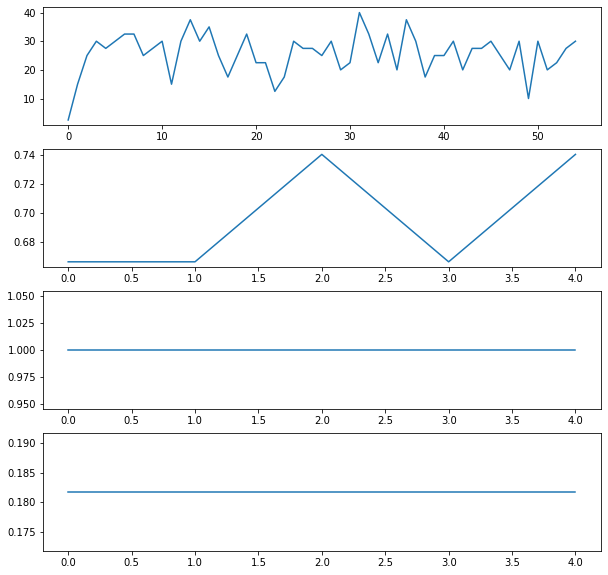

In [16]:
plt_list = [losses, accuracy, sensitivity, specificity]
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(plt_list[i])

## ROC曲线可视化


ROC曲线下的面积为AUC，这个面积（下面打印的结果）如果大于0.5就证明具有一定价值，越接近1越好。如果实验完全随机，那么面积就等于0.5，就相当于p用没有

0.5180361305361305


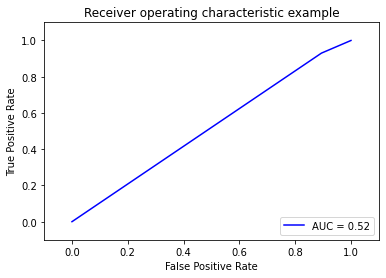

In [17]:
# coding=UTF-8
from sklearn import metrics
import matplotlib.pylab as pylab

# 这个GTlist是真实标签
GTlist = labels
# 这个是预测值，
Problist = preds



## 下面的不要改变
fpr, tpr, thresholds = metrics.roc_curve(GTlist, Problist, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
print(roc_auc)

 
pylab.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
pylab.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
pylab.xlim([-0.1, 1.1])
pylab.ylim([-0.1, 1.1])
pylab.xlabel('False Positive Rate') #横坐标是fpr
pylab.ylabel('True Positive Rate')  #纵坐标是tpr
pylab.title('Receiver operating characteristic example')
pylab.show()

## 当所有超参数调整好的时候，在测试集上运行一次，作为最终的accuracy，请记录下来

In [18]:
acc, sen, spe = evaluate_accuracy(test_loader, xx)
print('Accuracy on test set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))

total validation set data:55, numbers of accurately labeled data:33
Accuracy on test set:0.5999999642372131, 	Sensitivity on test set:1.0, 	Specificity on test set:0.08571428571428572


In [19]:
# ################################### test
# # clf = SVC(kernel='linear')
# # clf.fit(x_total, y_total)
# # pred = clf.predict(x_total)
# print(np.sum(preds==labels))
# # print(f"Classification report for classifier {xx>0.5}:\n"
# #       f"{metrics.classification_report(labels, preds)}\n")
# disp = metrics.plot_confusion_matrix(xx, x_train, y_train)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# ADNI

In [20]:
data_adni = sio.loadmat('ADNI.mat')
x_positive = data_adni['NC']
x_negative = data_adni['AD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

有52个正样本，有51个负样本，一共有103个样本
x原本是只有一个特征的，为294维
(52, 186) (51, 186) (103, 186) (52,) 51 52 186


# FTD_90_200_fMRI

In [21]:
data_ftd = sio.loadmat('FTD_90_200_fMRI.mat')
x_positive = data_ftd['NC']
x_negative = data_ftd['FTD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

有86个正样本，有95个负样本，一共有181个样本
x原本是只有一个特征的，为294维
(86, 90, 200) (95, 90, 200) (181, 90, 200) (86,) 95 86 90
